In [9]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [3]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [4]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs= 100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 10s 6ms/step - loss: 147.1349 - val_loss: 148.5529
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 147.0505 - val_loss: 148.6828
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 147.0008 - val_loss: 148.3661
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 146.9181 - val_loss: 148.4115
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 146.9116 - val_loss: 148.7008
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 146.8306 - val_loss: 148.5407
Epoch 7/100
1875/1875 [==============================] - 10s 5ms/step - loss: 146.7681 - val_loss: 148.2926
Epoch 8/100
1875/1875 [==============================] - 10s 5ms/step - loss: 146.7258 - val_loss: 148.3264
Epoch 9/100
1875/1875 [==============================] - 10s 6ms/step - loss: 146.6545 - val_loss: 148.3080
Epoch 10/100
1875/1875 [=====

1875/1875 [==============================] - 7s 4ms/step - loss: 144.3156 - val_loss: 146.9590
Epoch 77/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.2823 - val_loss: 146.9201
Epoch 78/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.2355 - val_loss: 146.9355
Epoch 79/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.2331 - val_loss: 147.1133
Epoch 80/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.1849 - val_loss: 146.8494
Epoch 81/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.1763 - val_loss: 146.8474
Epoch 82/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.1593 - val_loss: 146.8543
Epoch 83/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.1390 - val_loss: 147.1193
Epoch 84/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.0948 - val_loss: 146.7515
Epoch 85/100
1875/1875 [=================

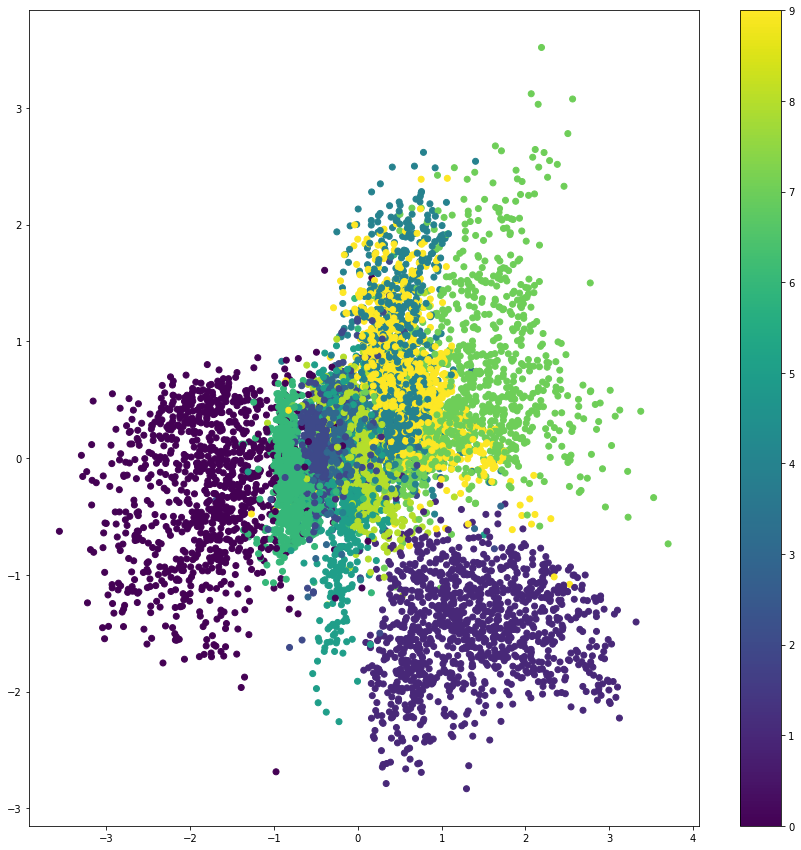

In [28]:
x_test_encoded = np.array(encoder.predict(x_test, batch_size=10))
plt.figure(figsize=(15, 15))
plt.scatter(x_test_encoded[0,:, 0], x_test_encoded[0,:, 1], c=y_test)
plt.colorbar()
plt.show()

In [29]:
# Because the VAE is a generative model, we can also use it to generate new digits! 
# Here we will scan the latent plane, sampling latent points at regular intervals, 
# and generating the corresponding digit for each of these points. This gives us a visualization
# of the latent manifold that "generates" the MNIST digits.

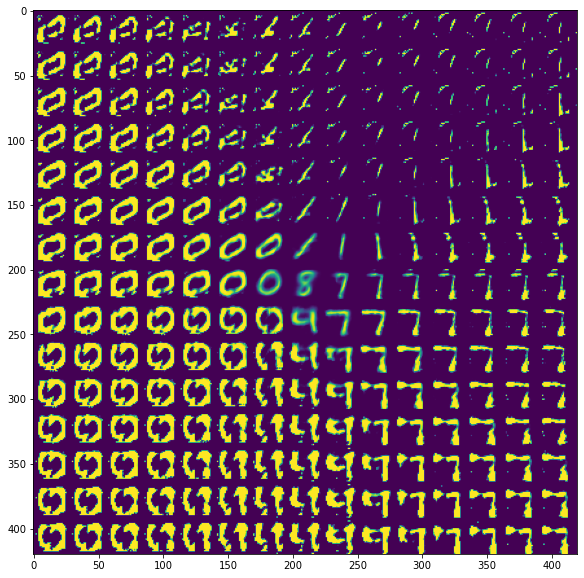

In [30]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()